In [65]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List

from fedlab.main.fedlab_benchmarks.leaf.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    


In [66]:
print(torch.__version__)




2.0.1+cu117


In [67]:
def get_femnist_shakespeare_dataset(**args):
    if args['dataset'] == 'femnist' or args['dataset'] == 'shakespeare':
        trainloader, testloader = get_LEAF_dataloader(dataset=args['dataset'],
                                                      client_id=args['rank'])
    else:
        raise ValueError("Invalid dataset:", args['dataset'])
    return trainloader, testloader

In [68]:

train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 62
epoch_total = 1

for i in range(num_nodes):
    args = {'dataset': 'femnist', 'rank': i}
    trainloader, testloader = get_femnist_shakespeare_dataset(**args)
    train_loaders.append(trainloader)
    test_loaders.append(testloader)

#loader = zip(train_loaders, test_loaders)



In [69]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(train_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x000002EDBFC0B2B0>, <torch.utils.data.dataloader.DataLoader object at 0x000002ED074E5B40>, <torch.utils.data.dataloader.DataLoader object at 0x000002ED074E7160>, <torch.utils.data.dataloader.DataLoader object at 0x000002ED074E5B70>, <torch.utils.data.dataloader.DataLoader object at 0x000002ED074E7C40>]
343


In [70]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [71]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()

In [72]:

x_i_j = {}
s_i = {}

In [73]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.f1_score = 0.0


        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, num_class)
        ).to(device)

        '''
        only_digits=False
        self.network = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10 if only_digits else 62),
        nn.ReLU()
        ).to(device)
        '''
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
        return sum(losses)/len(losses)
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        test_accuracy = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == data_y).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            labels.append(data_y.cpu())
            
            test_running_losses.append(loss.item())
            print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
            test_accuracy.append(100 * correct / total)
        
        #print(predictions)
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        self.f1_score= f1_score(labels, predictions, average="weighted")
        self.test_accuracy = test_accuracy[-1]
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        #print("test loss ",self.test_loss)
       
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(0, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])
    







In [74]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  343
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  372
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  364
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  358
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  284
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [75]:
losses = []
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
for i in tqdm(range(epoch_total)):
    epoch_losses = []
    for node in nodes:
        loss = node.train_epoch()
        epoch_losses.append(loss)
    losses.append(epoch_losses)

    x_i_j = {}
    s_i = {}
    for node in nodes:
        node.share_x_ij()
    
    for node in nodes:
        node.share_s_i()
    
    #av_state = {}
    #print(s_i[0])
    #for key in s_i[0].keys():
    #    av_state[key]=torch.mean(torch.tensor([s_i[i][key] for i in s_i]), dim=[0])
    averaged_state = {}
    for key in s_i[0].keys():
        param_value = 0
        for i in s_i:
            param_value += s_i[i][key]
        
        averaged_state[key] = param_value/num_nodes

    for node in nodes:
        node.network.load_state_dict(averaged_state)

    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\ankit\AppData\Local\Temp\ipykernel_13260\2074874273.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()
100%|██████████| 1/1 [00:00<00:00, 16.37it/s]

Time taken by FL with SMPC 0.06409287452697754


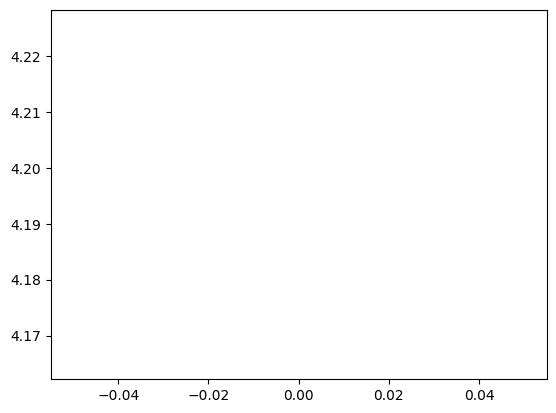

In [76]:
plt.plot(losses)

In [59]:
#nodes = [FederatedNode(l, i) for i,l in enumerate(test_loaders)]

test_losses = []
with torch.no_grad():
    for i, node in enumerate(nodes):
        print()
        print("Node ", i)
        node.testing()
        #test_losses.append(node.test_loss)
        print("Node Test Accuracy", node.test_accuracy)
        print("Node Test loss", node.test_loss)
        print("Node F1_Score ", node.f1_score)

        


Node  0
Epoch 1 test loss: 4.109
Node Test Accuracy 15.384615384615385
Node Test loss 4.108736991882324
Node F1_Score  0.04102564102564103

Node  1
Epoch 1 test loss: 4.120
Node Test Accuracy 7.142857142857143
Node Test loss 4.120253086090088
Node F1_Score  0.009523809523809525

Node  2
Epoch 1 test loss: 4.120
Node Test Accuracy 9.75609756097561
Node Test loss 4.12024450302124
Node F1_Score  0.017344173441734414

Node  3
Epoch 1 test loss: 4.122
Node Test Accuracy 5.0
Node Test loss 4.1216654777526855
Node F1_Score  0.0047619047619047615

Node  4
Epoch 1 test loss: 4.120
Node Test Accuracy 6.25
Node Test loss 4.119555950164795
Node F1_Score  0.007352941176470588


In [60]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  343
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  372
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  364
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  358
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  284
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [61]:
start_time = time.time()
for i in tqdm(range(5)):
    epoch_losses = []
    
    for node in nodes:
        loss = node.train_epoch()
        epoch_losses.append(loss)
    losses.append(epoch_losses)


    
    av_state = {}
    
    
    
    states = [i.network.state_dict() for i in nodes]
    av_state = {}
    for key in states[0]:
        av_state[key] = sum([s[key] for s in states])/num_nodes
    for node in nodes:
        node.network.load_state_dict(av_state)

time_FL = time.time() - start_time

print("Time taken by FL without SMPC", time_FL)
    

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\ankit\AppData\Local\Temp\ipykernel_13260\2074874273.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()
100%|██████████| 5/5 [00:00<00:00, 21.59it/s]

Time taken by FL without SMPC 0.2345585823059082


In [77]:
#nodes = [FederatedNode(l, i) for i,l in enumerate(test_loaders)]

test_losses = []
with torch.no_grad():
    for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        node.testing()
        #test_losses.append(node.test_loss)
        # print("Node Test Accuracy", node.test_accuracy)
        # print("Node Test loss", node.test_loss)
        # print("Node F1_Score ", node.f1_score)

print("Done")        


Node  0
Epoch 1 test loss: 4.123
Node Test Accuracy 0.0
Node Test loss 4.122610569000244
Node F1_Score  0.0

Node  1
Epoch 1 test loss: 4.107
Node Test Accuracy 2.380952380952381
Node Test loss 4.107358455657959
Node F1_Score  0.0012210012210012208

Node  2
Epoch 1 test loss: 4.119
Node Test Accuracy 0.0
Node Test loss 4.118530750274658
Node F1_Score  0.0

Node  3
Epoch 1 test loss: 4.122
Node Test Accuracy 5.0
Node Test loss 4.122112274169922
Node F1_Score  0.0064516129032258064

Node  4
Epoch 1 test loss: 4.133
Node Test Accuracy 3.125
Node Test loss 4.1330413818359375
Node F1_Score  0.0027173913043478264


In [63]:
#print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [64]:
global_mean = 0.0
global_std = 0.0
eqn1= 0.0 
eqn2 = 0.0
eqn3 = 0.0
for node in nodes:
    eqn1 += node.mean * node.dataset_size
    eqn2 += node.dataset_size 
    eqn3 += node.std


global_mean = eqn1/eqn2
global_std = eqn3/eqn2
print("Global Mean", global_mean.shape)
print("Global std ", global_std.shape)
#plt.imshow(global_mean.squeeze())
#plt.imshow(global_std.squeeze())

Global Mean torch.Size([1, 28, 28])
Global std  torch.Size([1, 28, 28])
